## Process Raw Anti-Vax dataset from Kaggle and save regressors for later processing by Prophet

In [20]:
!pip install fbprophet

In [0]:
from google.colab import drive

import pandas as pd
from pandas import Grouper
import numpy as np
import matplotlib.pyplot as plt


In [22]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Obtain

In [23]:
# Data has been downloaded from Kaggle and the raw csv is uploaded to 
# Google Drive
av_df = pd.read_csv('/content/drive/My Drive/Project/posts_full.csv',
                    parse_dates=['timestamp'])
av_df.shape

(89867, 154)

In [24]:
# lot of columns here
av_df.columns[:30]

Index(['Unnamed: 0', 'article_host', 'article_name', 'article_subtitle',
       'hashtags', 'img-label', 'img_src', 'linked_profiles', 'links', 'text',
       'timestamp', 'has_article', 'text_length', 'num_hashtags', 'has_text',
       'num_linked_profiles', 'num_links', 'text_tokenized', 'num_tokens',
       'text_tokenized_filtered', 'text_tokenized_lemmatized', 'num_words',
       'num_periods', 'percent_periods', 'num_exclamations',
       'percent_exclamations', 'num_questionms', 'percent_questionms',
       'num_equals', 'percent_equals'],
      dtype='object')

In [25]:
# many of the middle columns are simply counts of POS tags
# sentiment is already scored and added here.
av_df.columns[30:60]

Index(['num_dollars', 'percent_dollars', 'ttr', 'page_name', 'anti_vax',
       'page_name_adjusted', 'sentiment_neg', 'sentiment_neu', 'sentiment_pos',
       'sentiment_compound', 'readability_smog_index',
       'readability_gunning_fog', 'readability_flesch_kincaid_grade',
       'num_pos_basic_a', 'num_pos_basic_n', 'num_pos_basic_r',
       'num_pos_basic_v', 'num_pos_CC', 'num_pos_RBR', 'num_pos_NNS',
       'num_pos_$', 'num_pos_DT', 'num_pos_VBG', 'num_pos_PRP$', 'num_pos_JJ',
       'num_pos_PRP', 'num_pos_TO', 'num_pos_POS', 'num_pos_VBP',
       'num_pos_WRB'],
      dtype='object')

In [26]:
# and the final columns are all document frequencies
av_df.columns[124:]

Index(['cause', 'discrep', 'tentat', 'certain', 'inhib', 'incl', 'excl',
       'percept', 'see', 'hear', 'feel', 'bio', 'body', 'health', 'sexual',
       'ingest', 'relativ', 'motion', 'space', 'time', 'work', 'achiev',
       'leisure', 'home', 'money', 'relig', 'death', 'assent', 'nonflu',
       'filler'],
      dtype='object')

# Scrub

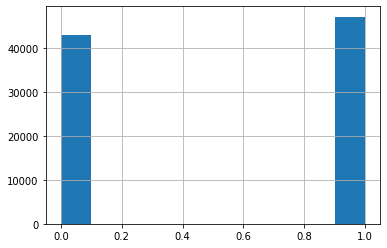

In [27]:
# There are more anti-vax posts than vax, but not by much
av_S = av_df['anti_vax'].astype(int)
av_S.hist()

In [28]:
# verify that anti_vax == True corresponds to posts that are indeed anit-vax
pd.set_option('max_colwidth',255)
av_df[['text', 'anti_vax']][av_df['anti_vax']==True][:30]

,text,anti_vax
1953,Mandatory/Forced Vaccinations a Blatant Violation of the Nuremberg Code ~ See article & videos here: - Follow TLB on Twitter at https://twitter.com/thetlbprojectMandatory/Forced Vaccinations a Blatant Violation of the Nuremberg Code ~ See article & v...,True
1954,NaN,True
1955,"Since she only had a temperature of 101.5 degrees, she “took Tylenol, drank some Gatorade and rested the rest of the day.”1 Shradar also contacted the women’s clinic at Providence (where she was regularly treated) who “prescribed her a flu medication ...",True
1956,"Wait? If vaccines were safe and effective why do they have coding for injuries, a vaccine injury compensation program and why did the Supreme Court state that they are unavoidably unsafe? Are you confused? Maybe they are always safe?",True
1957,"""Dr. Yehuda Shoenfeld is an immunologist who heads the Zabludowicz Center for Autoimmune Diseases, which was created by Poju Zabludowicz. He is also on the scie...ntific advisory board for the Children’s Medical Safety Research Institute. He claims to...",True
1958,"We are not a Science Experiment, certainly don’t let your Children be one #VaccinesExposed #ForcedPoison #FreedomExposed #unvaccinated #TheTruthAboutVaccines #WhatsInYourVaccines",True
1959,NaN,True
1960,"Are we next? That is why we need to have everyone on board contacting Senators, Representatives, Legislators and sharing info with friends and family, or this might become a reality for the US too!!",True
1961,NaN,True
1962,NaN,True


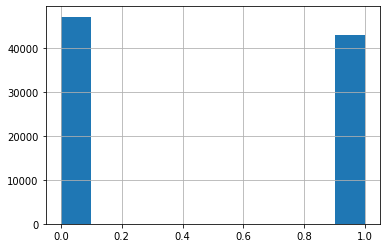

In [29]:
# reverse the double negative!
# note: this is enforcing an assumption that a post is either anti-vax or
#       pro-vax! This may not be the case. It could simiply be anti-vax or
#       other (pro/neutral/off topic)
av_df['pro_vax'] = ~av_df['anti_vax']
av_df['pro_vax'].astype(int).hist()
av_df['i_anti_vax'] = av_df['anti_vax'].astype(int)
av_df['i_pro_vax'] = av_df['pro_vax'].astype(int)

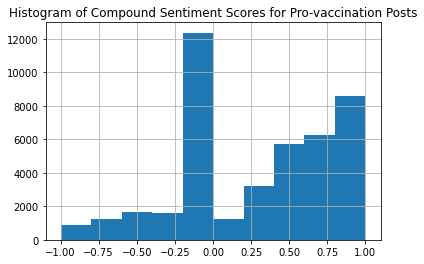

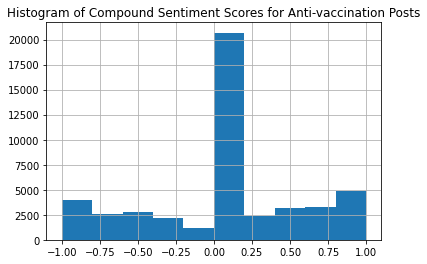

In [30]:
av_df['pro_vax_sent'] = av_df['sentiment_compound'] * av_df['i_pro_vax']
av_df['anti_vax_sent'] = av_df['sentiment_compound'] * av_df['i_anti_vax']
av_df[av_df['pro_vax'] == True]['pro_vax_sent'].hist()
plt.title("Histogram of Compound Sentiment Scores for Pro-vaccination Posts")
plt.show()
av_df[av_df['anti_vax'] == True]['anti_vax_sent'].hist()
plt.title("Histogram of Compound Sentiment Scores for Anti-vaccination Posts")
plt.show()

Many pro-vaccination posts are slightly negative with many of them being postitive to very postiive.
Many anti-vaccination posts are slightly positive with others more spread from postive to negative.

In [0]:
# limit the dataframe to just the sentiment values and number of posts
pro_sent = pd.DataFrame(av_df[av_df['pro_vax']==True][['timestamp', 'sentiment_neg', 'sentiment_neu', 'sentiment_pos', 'i_pro_vax']], copy=True)
anti_sent = pd.DataFrame(av_df[av_df['anti_vax']==True][['timestamp', 'sentiment_neg', 'sentiment_neu', 'sentiment_pos', 'i_anti_vax']], copy=True)

In [32]:
pro_sent.describe()

,sentiment_neg,sentiment_neu,sentiment_pos,i_pro_vax
count,42807.000000,42807.000000,42807.000000,42807.0
mean,0.043263,0.726241,0.161465,1.0
std,0.092677,0.266001,0.178760,0.0
min,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.650000,0.000000,1.0
50%,0.000000,0.785000,0.126000,1.0
75%,0.050000,0.901000,0.249000,1.0
max,1.000000,1.000000,1.000000,1.0


In [33]:
# group by weeks taking sums then divide out the counts to get means.
# this allows for the post total to be preserved
pro_weeks = pd.DataFrame( \
    pro_sent.groupby(Grouper(key='timestamp',
                             freq='W-SUN')).sum().reset_index(), copy=True)
pro_weeks['sentiment_neg'] = pro_weeks['sentiment_neg'] / pro_weeks['i_pro_vax']
pro_weeks['sentiment_pos'] = pro_weeks['sentiment_pos'] / pro_weeks['i_pro_vax']
pro_weeks['sentiment_neu'] = pro_weeks['sentiment_neu'] / pro_weeks['i_pro_vax']
pro_weeks.describe()

,sentiment_neg,sentiment_neu,sentiment_pos,i_pro_vax
count,274.000000,274.000000,274.000000,274.000000
mean,0.040725,0.716602,0.161117,156.229927
std,0.011290,0.045758,0.023997,125.715017
min,0.013182,0.553459,0.105284,33.000000
25%,0.033517,0.693503,0.145746,77.250000
50%,0.040301,0.727201,0.159934,127.000000
75%,0.048260,0.749499,0.174056,203.000000
max,0.080529,0.819121,0.287036,897.000000


In [34]:
# do the same for the anti-side
ant_weeks = pd.DataFrame( \
    anti_sent.groupby(Grouper(key='timestamp',
                             freq='W-SUN')).sum().reset_index(), copy=True)
ant_weeks['sentiment_neg'] \
    = ant_weeks['sentiment_neg'] / ant_weeks['i_anti_vax']
ant_weeks['sentiment_pos'] \
    = ant_weeks['sentiment_pos'] / ant_weeks['i_anti_vax']
ant_weeks['sentiment_neu'] \
    = ant_weeks['sentiment_neu'] / ant_weeks['i_anti_vax']
ant_weeks

,timestamp,sentiment_neg,sentiment_neu,sentiment_pos,i_anti_vax
0,2014-01-05,0.000000,0.000000,0.000000,4
1,2014-01-12,0.045261,0.377522,0.055435,23
2,2014-01-19,0.075286,0.601286,0.066229,35
3,2014-01-26,0.071974,0.596949,0.100256,39
4,2014-02-02,0.104514,0.540371,0.069371,35
...,...,...,...,...,...
270,2019-03-10,0.056768,0.591647,0.076231,966
271,2019-03-17,0.058332,0.594191,0.072805,1125
272,2019-03-24,0.066228,0.598520,0.074447,1181
273,2019-03-31,0.071941,0.646460,0.069017,1477


In [0]:
# save these to google drive. They will get used later.
ant_weeks.to_csv('/content/drive/My Drive/Project/anti_vax_by_week.csv')
pro_weeks.to_csv('/content/drive/My Drive/Project/pro_vax_by_week.csv')

# keep this here if the data doesn't seem to get updated.
# don't need to unmount, but the "flush" may come in handy!
#drive.flush_and_unmount()